In [1]:
import scanpy as sc
import sys
sys.path.append(r"D:\Scunpair_Project\Diagonal-integration")
import mycode
import pandas as pd
adata_merfish = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\MERFISH+scRNA\merfish0.h5ad")
adata_rna = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\MERFISH+scRNA\rna0.h5ad")
labels_merfish = pd.read_csv(r"D:\Scunpair_Project\Dataset\MERFISH+scRNA\MERFISH_mouse1_cluster.txt", sep='\t')
celltype_merfish = labels_merfish['cluster_main'].values
labels_rna = pd.read_csv(r"D:\Scunpair_Project\Dataset\MERFISH+scRNA\scRNA_cluster.txt", sep='\t')
celltype_rna = labels_rna['cluster_main'].values
adata_merfish.obs['celltype'] = celltype_merfish
adata_rna.obs['celltype'] = celltype_rna

In [2]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_merfish.var_names) & set(adata_rna.var_names)))
adata_merfish = adata_merfish[:, cm_genes]
adata_rna = adata_rna[:, cm_genes]

sc.pp.normalize_total(adata_merfish)
sc.pp.log1p(adata_merfish)

sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)

sc.pp.scale(adata_merfish, max_value=10)
sc.pp.scale(adata_rna, max_value=10)

#mycode.utils.batch_scale(adata_merfish)
#mycode.utils.batch_scale(adata_rna)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
model = mycode.Model(adata_merfish, adata_rna, batch_size=500, 
                           training_steps=1001, seed=1234, celltype_col='celltype',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaAlign = 1.0, lambdamGAN = 1.0, lambdabGAN = 1.0, lambdaGeo=0.5, n_KNN = 30, mode = 'strong', use_prior = False, link_feat_num = 153)

In [4]:
model.train()
model.eval()

Training started at: Fri Sep 26 16:18:09 2025
Step 0 | loss_Recon: 19.3213 | loss_LA: 20.0786 | loss_Align: 0.4319 | loss_Geo: 0.1981 | loss_mGAN vs loss_mDis: -1.3754 vs 1.3792 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_Recon: 10.6894 | loss_LA: 0.0943 | loss_Align: 0.0881 | loss_Geo: 0.0419 | loss_mGAN vs loss_mDis: -1.0429 vs 1.0634 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Training finished. Time: 28.43 sec
Evaluation started at: Fri Sep 26 16:18:38 2025
Evaluation completed at: Fri Sep 26 16:18:38 2025
Total evaluation time: 0.30 seconds
Processed 94743 samples
Latent space shape: (94743, 16)


In [5]:
import anndata as ad
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_merfish.obs, adata_rna.obs])
adata_integrated.obs['modality'] = ['MERFISH'] * adata_merfish.shape[0] + ['RNA'] * adata_rna.shape[0]

In [6]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.1)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


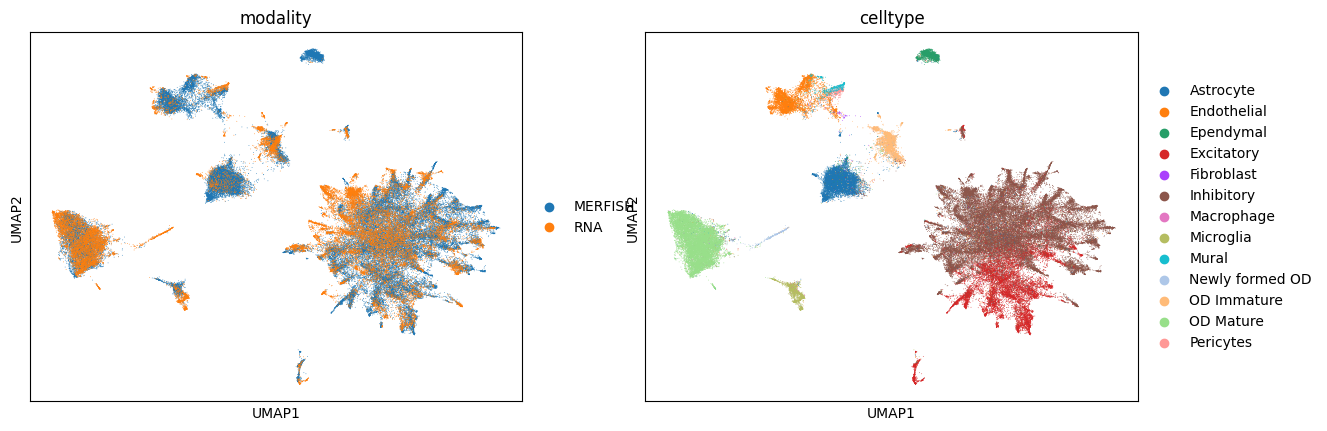

In [7]:
sc.pl.umap(adata_integrated, color=['modality','celltype'])